In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Imports:

In [2]:
#all  imports
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from math import isnan
from networkx.algorithms.community.centrality import girvan_newman

All functions:

In [3]:
#read all data from CSV file, and show info about duplicates in it
def readFromCsvCheckDuplicates(filePath):
    temp = pd.read_csv(filePath)
    print("Dimensions of data: " + str(temp.shape))
    tempDuplicates = temp[temp.duplicated()]
    if tempDuplicates.shape[0] == 0:
        print("No duplicates in data")
    else:
        print("Duplicates are:")
        print(tempDuplicates)
    return temp
#plot all data from column in dataframe
def plot_column(nameOfColumn):
    atp_matches_data_2020.groupby(nameOfColumn)['id']\
        .nunique().plot(kind='bar')
    plt.show()
#check if column contains nulls, and if it is unique
def checkColumnNullsAndUnique(dataTmp):
    for column in dataTmp.columns:
        print(column+"\\\t"+ str(dataTmp[column].isnull().values.any())
              + "\\\t"+str(dataTmp[column].is_unique))
#set default values for rank and points if they are nulls
def checkNullsRankAndPoints(rankColumn, rankPointsColumn):
    maska = (atp_matches_data_2020[rankColumn].isnull())
    for index, row in atp_matches_data_2020[maska].iterrows():
        atp_matches_data_2020.at[index,rankColumn] = 2272
        atp_matches_data_2020.at[index,rankPointsColumn] = 0

Reading and cleaning data:

In [4]:
#read all matches from 2020
atp_matches_data_2020 = readFromCsvCheckDuplicates("atp_matches_2020.csv")

Dimensions of data: (1447, 49)
No duplicates in data


In [5]:
#read all player info
atp_players_data_info = readFromCsvCheckDuplicates("atp_players.csv")

Dimensions of data: (54975, 6)
No duplicates in data


In [6]:
#read only 2020 atp ranking data
data_rankings_atp_20s = readFromCsvCheckDuplicates("atp_rankings_20s.csv")
data_rankings_atp_20s = data_rankings_atp_20s[
    (data_rankings_atp_20s['ranking_date'] >= 20200101) &
    (data_rankings_atp_20s['ranking_date'] < 20210101)]
data_rankings_atp_20s = data_rankings_atp_20s.drop_duplicates()
print(data_rankings_atp_20s.shape)

Dimensions of data: (53157, 4)
No duplicates in data
(53157, 4)


In [7]:
#add id column to matches data
atp_matches_data_2020['id'] = atp_matches_data_2020.index
print(atp_matches_data_2020.shape)

(1447, 50)


In [8]:
#delete unnecessary columns from matches data
list_to_delete_columns = ['draw_size', 'match_num', 'winner_seed',
                          'winner_entry', 'winner_ht', 'loser_ht',
                          'loser_seed', 'loser_entry', 'score',
                          'best_of', 'minutes', 'w_ace', 'w_df',
                          'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
                          'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace',
                          'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
                          'l_2ndWon', 'l_SvGms', 'l_bpSaved',
                          'l_bpFaced', 'winner_name', 'winner_hand',
                          'winner_age', 'winner_ioc', 'loser_name',
                          'loser_hand', 'loser_age', 'loser_ioc']
for column in list_to_delete_columns:
    del atp_matches_data_2020[column]
print(atp_matches_data_2020.shape)

(1447, 13)


In [9]:
#plotting all columns
#for column in atp_matches_data.columns:
   # plot_column(column)

In [10]:
#set default values if null in winner and loser rank and points data
checkNullsRankAndPoints('winner_rank','winner_rank_points')
checkNullsRankAndPoints('loser_rank','loser_rank_points')

In [11]:
#check if columns are nulls or unique
checkColumnNullsAndUnique(atp_matches_data_2020)
print('---------------------------------------')
checkColumnNullsAndUnique(atp_players_data_info)

tourney_id\	False\	False
tourney_name\	False\	False
surface\	False\	False
tourney_level\	False\	False
tourney_date\	False\	False
winner_id\	False\	False
loser_id\	False\	False
round\	False\	False
winner_rank\	False\	False
winner_rank_points\	False\	False
loser_rank\	False\	False
loser_rank_points\	False\	False
id\	False\	True
---------------------------------------
id\	False\	True
name\	True\	False
surname\	True\	False
hand\	False\	False
date_of_birth\	True\	False
country\	True\	False


In [12]:
#get all players from all matches
list_winner_id = set(atp_matches_data_2020['winner_id'].unique())
list_loser_id = set(atp_matches_data_2020['loser_id'].unique())
all_current_user_ids = list_winner_id.union(list_loser_id)
print(len(all_current_user_ids))

345


Making Graph:

In [13]:
#counting different tourneys
all_pairs_player_tourney = set()
for _,row in atp_matches_data_2020.iterrows():
   all_pairs_player_tourney.add((row['winner_id'], row['tourney_id']))
   all_pairs_player_tourney.add((row['loser_id'], row['tourney_id']))

tourneys_counter_by_player = {}
for pair in all_pairs_player_tourney:
    if pair[0] in tourneys_counter_by_player.keys():
        tourneys_counter_by_player[pair[0]] +=1
    else:
        tourneys_counter_by_player[pair[0]]=1


In [14]:
#putting all nodes in graph
G = nx.Graph()
for userId in all_current_user_ids:
    player = atp_players_data_info[atp_players_data_info['id']==userId]
    all_player_rankings = data_rankings_atp_20s[data_rankings_atp_20s['player']==userId]
    temp_rank = all_player_rankings['rank'].dropna().mean()
    if isnan(temp_rank):
        temp_rank=2272.0
    temp_points=all_player_rankings['points'].dropna().mean()
    if isnan(temp_points):
        temp_points=0.0
    G.add_node(str(userId), name=player['name'].values[0],
               surname=player['surname'].values[0],
               country=player['country'].values[0],
               hand=player['hand'].values[0],
               dateOfBirth=player['date_of_birth'].values[0],
               tourneyNum=tourneys_counter_by_player[userId],
               avgRank=temp_rank,
               avgPoints=temp_points)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 345
Number of edges: 0
Average degree:   0.0000


In [15]:
#creating edges
for _, match in atp_matches_data_2020.iterrows():
    if G.has_edge(str(match['winner_id']), str(match['loser_id'])):
        G[str(match['winner_id'])][str(match['loser_id'])]['weight']+=1
    else:
        G.add_edge(str(match['winner_id']), str(match['loser_id']), weight=1)
        G[str(match['winner_id'])][str(match['loser_id'])]['lowerId']=0
        G[str(match['winner_id'])][str(match['loser_id'])]['higherId']=0

    if match['winner_id']>match['loser_id']:
        G[str(match['winner_id'])][str(match['loser_id'])]['higherId']+=1
    else:
        G[str(match['winner_id'])][str(match['loser_id'])]['lowerId']+=1
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 345
Number of edges: 1325
Average degree:   7.6812


In [16]:
#write to a file
output_path = "Basic2020.gml"
nx.write_gml(G, output_path)

In [17]:
#pitanje 2 - izbaciti citacemo iz gephija
sorted_by_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)
for player in sorted_by_degree:
    player2 = atp_players_data_info[atp_players_data_info['id']==(int(player[0]))]
    print(player2)
    print(player[1])

           id    name surname hand  date_of_birth country
26078  126094  Andrey  Rublev    R     19971020.0     RUS
43
           id   name          surname hand  date_of_birth country
45034  200000  Felix  Auger Aliassime    R     20000808.0     CAN
37
           id      name    surname hand  date_of_birth country
26758  126774  Stefanos  Tsitsipas    R     19980812.0     GRE
34
          id   name   surname hand  date_of_birth country
4919  104925  Novak  Djokovic    R     19870522.0     SRB
32
           id   name    surname hand  date_of_birth country
11559  111575  Karen  Khachanov    R     19960521.0     RUS
31
           id    name surname hand  date_of_birth country
34754  134770  Casper    Ruud    R     19981222.0     NOR
31
          id             name      surname hand  date_of_birth country
6028  106043  Diego Sebastian  Schwartzman    R     19920816.0     ARG
30
          id    name   surname hand  date_of_birth country
6406  106421  Daniil  Medvedev    R     19960211.0  

In [18]:
#pitanje 6
numOfPlayersByCountryCounter = {}
for player in G.degree:
    player2 = atp_players_data_info[atp_players_data_info['id']==(int(player[0]))]
    if player2['country'].values[0] in numOfPlayersByCountryCounter.keys():
        numOfPlayersByCountryCounter[player2['country'].values[0]] +=1
    else:
        numOfPlayersByCountryCounter[player2['country'].values[0]]=1
print(dict(sorted(numOfPlayersByCountryCounter.items(), key=lambda item: item[1], reverse=True)))
plt.bar(*zip(*numOfPlayersByCountryCounter.items()))
plt.show()

{'USA': 28, 'FRA': 22, 'ITA': 18, 'GER': 15, 'ESP': 14, 'AUS': 14, 'ARG': 13, 'RUS': 9, 'SRB': 8, 'CAN': 8, 'JPN': 7, 'SUI': 6, 'CRO': 5, 'GBR': 5, 'BEL': 5, 'IND': 5, 'SVK': 5, 'POL': 5, 'AUT': 4, 'NZL': 4, 'CZE': 4, 'POR': 4, 'FIN': 4, 'TPE': 4, 'CHI': 4, 'BUL': 4, 'GEO': 4, 'URU': 3, 'BAR': 3, 'UKR': 3, 'LTU': 3, 'RSA': 3, 'ISR': 3, 'SLO': 3, 'EST': 3, 'KEN': 3, 'KAZ': 3, 'DEN': 3, 'BLR': 3, 'VEN': 3, 'HKG': 3, 'BRA': 3, 'INA': 3, 'EGY': 3, 'SRI': 3, 'PHI': 3, 'NOR': 3, 'VIE': 3, 'THA': 2, 'GUA': 2, 'ESA': 2, 'PAR': 2, 'UZB': 2, 'NED': 2, 'COL': 2, 'SWE': 2, 'TUR': 2, 'BOL': 2, 'HUN': 2, 'CRC': 2, 'MDA': 2, 'DOM': 2, 'PAK': 2, 'ZIM': 2, 'MEX': 2, 'PER': 2, 'BIH': 2, 'GRE': 2, 'ECU': 2, 'TUN': 2, 'ALG': 1, 'MAR': 1, 'LAT': 1, 'LVA': 1, 'JAM': 1, 'SYR': 1, 'UNK': 1, 'CYP': 1, 'PUR': 1, 'KOR': 1}


In [19]:
#prosečan weight čvora

sum = 0.0
for edge in G.edges:
    sum += G.get_edge_data(*edge)['weight']
sum /= G.number_of_edges()
print(sum)

1.0920754716981131


In [20]:
#pitanje 11
player_rank_to_edge_weight=pd.DataFrame(columns=['avgWeight', 'rank'])
for node in G.nodes:
    sum = 0.0
    counter = 0
    for neighbor in nx.neighbors(G, node):
        sum+=G[node][neighbor]['weight']
        counter+=1
    sum /= counter
    player_rank_to_edge_weight = player_rank_to_edge_weight.append(
        pd.DataFrame([[sum, G.nodes[node]['avgRank']]], columns=['avgWeight', 'rank']))
print(player_rank_to_edge_weight)

    avgWeight        rank
0    1.058824   93.370370
0    1.000000  671.407407
0    1.045455   58.037037
0    1.000000  228.888889
0    1.095238   16.814815
..        ...         ...
0    1.120000   27.333333
0    1.000000  140.814815
0    1.000000  122.592593
0    1.000000   85.222222
0    1.000000  508.592593

[345 rows x 2 columns]


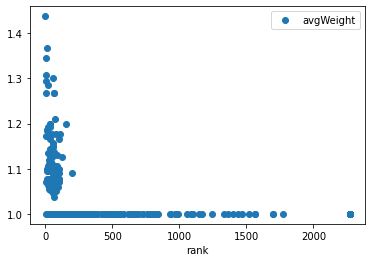

In [21]:
#pitanje 11
player_rank_to_edge_weight.plot(x='rank', y='avgWeight', style='o')
plt.show()

In [22]:
#pitanje 17
player_rank_to_degree=pd.DataFrame(columns=['degree', 'rank'])
for node in G.nodes:
    player_rank_to_degree = player_rank_to_degree.append(
        pd.DataFrame([[G.degree[node], G.nodes[node]['avgRank']]],
                     columns=['degree', 'rank']))
print(player_rank_to_degree)

   degree        rank
0      17   93.370370
0       1  671.407407
0      22   58.037037
0       5  228.888889
0      21   16.814815
..    ...         ...
0      25   27.333333
0       5  140.814815
0       6  122.592593
0      15   85.222222
0       1  508.592593

[345 rows x 2 columns]


In [23]:
#pitanje 17
player_rank_to_degree.plot(x='rank', y='degree', style='o')
plt.show()

In [24]:
#klasterisanje pitanje 10
id_player, clustering_coef = zip(*nx.clustering(G, weight = "weight").items())

nonZero = [(id_ig, cc)  for id_ig, cc in zip(id_player, clustering_coef) if cc > 0]

df = pd.DataFrame(nonZero, columns = ["id", "cc"])
df.sort_values('cc', inplace = True)
print(f"Max lokalni cc: {max(clustering_coef)}")
print(f"Prosečan cc: {nx.average_clustering(G)}")
print("Lokalni stepeni klasterisanja koji nisu nula:")
print(df)

Max lokalni cc: 0.33333333333333337
Prosečan cc: 0.09086792378213672
Lokalni stepeni klasterisanja koji nisu nula:
         id        cc
127  106198  0.006061
57   105575  0.011057
27   105155  0.011905
64   124079  0.022059
78   126214  0.022222
..      ...       ...
145  104327  0.333333
20   104999  0.333333
36   111460  0.333333
104  208364  0.333333
136  104229  0.333333

[158 rows x 2 columns]


In [25]:
#asortativnost pitanje 10
# asortativnost na osnovu netežinskog stepena čvora
print(f"Koeficijent asortativnosti na osnovu netežinskog stepena čvora: "
      f"{nx.degree_assortativity_coefficient(G)}")

# asortativnost na osnovu težinskog stepena čvora
print(f"Koeficijent asortativnosti na osnovu težinskog stepena čvora: "
      f"{nx.degree_assortativity_coefficient(G, weight='weight')}")

Koeficijent asortativnosti na osnovu netežinskog stepena čvora: 0.23815555973416275
Koeficijent asortativnosti na osnovu težinskog stepena čvora: 0.23637924173286778


In [26]:
#pitanje 9
gn = girvan_newman(G)
print(gn)

<generator object girvan_newman at 0x1D33EAE0>


In [27]:
#pitanje 9
tuple(sorted(c) for c in next(gn))

(['100644',
  '103333',
  '103565',
  '103819',
  '103852',
  '103893',
  '104229',
  '104259',
  '104269',
  '104291',
  '104312',
  '104327',
  '104424',
  '104468',
  '104527',
  '104542',
  '104545',
  '104586',
  '104655',
  '104656',
  '104660',
  '104665',
  '104678',
  '104731',
  '104745',
  '104755',
  '104792',
  '104797',
  '104871',
  '104898',
  '104901',
  '104918',
  '104919',
  '104925',
  '104926',
  '104999',
  '105011',
  '105023',
  '105030',
  '105053',
  '105062',
  '105074',
  '105077',
  '105138',
  '105147',
  '105155',
  '105156',
  '105173',
  '105208',
  '105216',
  '105226',
  '105227',
  '105311',
  '105332',
  '105341',
  '105357',
  '105359',
  '105373',
  '105376',
  '105379',
  '105406',
  '105413',
  '105430',
  '105432',
  '105434',
  '105441',
  '105449',
  '105453',
  '105477',
  '105487',
  '105497',
  '105526',
  '105539',
  '105550',
  '105554',
  '105575',
  '105577',
  '105583',
  '105613',
  '105614',
  '105633',
  '105643',
  '105649',
  '1

In [28]:
#pitanje 12
T = nx.k_core(G)
print(nx.info(T))
output_path = "core2020.gml"
nx.write_gml(T, output_path)
print(T.nodes)

Name: 
Type: Graph
Number of nodes: 74
Number of edges: 609
Average degree:  16.4595
['104755', '200000', '105936', '106426', '106078', '105916', '105732', '105550', '105815', '104926', '105676', '105062', '105430', '111815', '104468', '200005', '200175', '106378', '105332', '100644', '133430', '105683', '128034', '132283', '126203', '126207', '126774', '106421', '144750', '200282', '110602', '206173', '105077', '105932', '200221', '105227', '111513', '105379', '106432', '105173', '124187', '105138', '105526', '126205', '105613', '104731', '126952', '105807', '122330', '105554', '104745', '111442', '104792', '105583', '106065', '105777', '106233', '104527', '106099', '200325', '104655', '106415', '126094', '106043', '144895', '105643', '104925', '103852', '105577', '105357', '106329', '104545', '134770', '111575']


In [29]:
#pitanje 18
h, a = nx.hits(G)
print(dict(sorted(h.items(), key=lambda item: item[1], reverse=True)))
print('----------')
print(dict(sorted(a.items(), key=lambda item: item[1], reverse=True)))

{'126094': 0.021834106297657183, '104925': 0.02175154473956833, '126774': 0.021192283752058564, '106043': 0.019446398844988114, '100644': 0.018997359799017968, '106421': 0.0178996365508859, '106233': 0.017107857102748193, '104745': 0.016334629729872017, '200000': 0.016271051637560163, '133430': 0.013629097421780954, '105807': 0.013355270132521632, '105554': 0.013001563379662675, '206173': 0.01295215964928918, '105683': 0.012546729077632605, '105526': 0.012473989721778328, '134770': 0.012353897247959482, '122330': 0.012303746829839042, '105583': 0.012064141507239709, '111575': 0.011962568007960897, '200005': 0.011957090335034075, '105173': 0.011811049952062471, '105777': 0.011671814956731091, '106432': 0.011660339006948475, '105577': 0.011412404127625264, '132283': 0.01093996227090033, '128034': 0.010773101630249736, '105357': 0.01073445375256858, '106426': 0.01064207850501011, '105138': 0.010496222089170185, '104731': 0.010441472379201639, '105936': 0.010266827416491917, '200175': 0.01

In [30]:
#pitanje 24
player_to_match_number = {}
for node in G.nodes:
    sum = 0.0
    for neighbor in nx.neighbors(G, node):
        sum+=G[node][neighbor]['weight']
    if sum in player_to_match_number.keys():
        player_to_match_number[sum]+=1
    else:
        player_to_match_number[sum]=1

print(player_to_match_number)
plt.bar(*zip(*player_to_match_number.items()))
plt.show()

{18.0: 3, 1.0: 119, 23.0: 8, 5.0: 12, 2.0: 45, 20.0: 7, 4.0: 15, 6.0: 13, 22.0: 5, 3.0: 22, 15.0: 6, 39.0: 1, 34.0: 2, 32.0: 2, 7.0: 7, 8.0: 6, 46.0: 1, 9.0: 4, 16.0: 4, 28.0: 6, 31.0: 5, 10.0: 5, 12.0: 4, 27.0: 2, 14.0: 6, 33.0: 1, 30.0: 5, 17.0: 3, 26.0: 3, 51.0: 1, 21.0: 5, 11.0: 3, 13.0: 3, 19.0: 4, 42.0: 1, 25.0: 1, 29.0: 1, 41.0: 1, 35.0: 1, 44.0: 1, 38.0: 1}


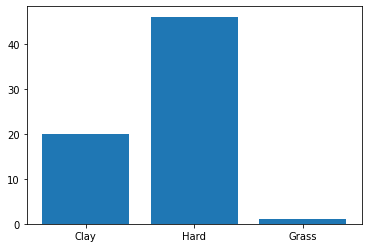

In [31]:
#pitanje 25
all_pairs_surface_tourney = set()
for _,row in atp_matches_data_2020.iterrows():
   all_pairs_surface_tourney.add((row['surface'], row['tourney_id']))

tourneys_counter_by_surface = {}
for pair in all_pairs_surface_tourney:
    if pair[0] in tourneys_counter_by_surface.keys():
        tourneys_counter_by_surface[pair[0]] +=1
    else:
        tourneys_counter_by_surface[pair[0]]=1
plt.bar(*zip(*tourneys_counter_by_surface.items()))
plt.show()

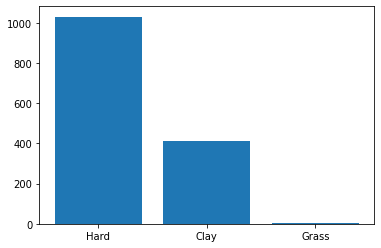

In [32]:
#pitanje 26
all_pairs_surface_matches = {}
for _,row in atp_matches_data_2020.iterrows():
   if row['surface'] in all_pairs_surface_matches.keys():
        all_pairs_surface_matches[row['surface']] += 1
   else:
        all_pairs_surface_matches[row['surface']]=1

plt.bar(*zip(*all_pairs_surface_matches.items()))
plt.show()

In [33]:
#pitanje 13
bridges = list(nx.bridges(G))
player_bridges = {}
for edge in bridges:
    if edge[0] in player_bridges.keys():
        player_bridges[edge[0]] += 1
    else:
        player_bridges[edge[0]]=1
    if edge[1] in player_bridges.keys():
        player_bridges[edge[1]] += 1
    else:
        player_bridges[edge[1]]=1
print(dict(sorted(player_bridges.items(), key=lambda item: item[1], reverse=True)))

{'126204': 3, '133975': 2, '209080': 2, '105656': 2, '108739': 2, '104291': 2, '209226': 2, '105432': 2, '105815': 2, '117356': 2, '105155': 2, '105827': 2, '106232': 2, '106397': 2, '144687': 2, '106210': 2, '136440': 2, '202065': 2, '126203': 2, '200005': 2, '106198': 2, '111761': 2, '208518': 2, '208029': 2, '200620': 2, '105688': 2, '202261': 2, '106218': 2, '132374': 2, '106220': 2, '106150': 2, '126774': 2, '144932': 2, '106233': 2, '104467': 1, '122533': 1, '110686': 1, '105467': 1, '127143': 1, '108763': 1, '144826': 1, '104656': 1, '134770': 1, '209119': 1, '144775': 1, '108772': 1, '105311': 1, '209225': 1, '202462': 1, '134886': 1, '209872': 1, '127326': 1, '123795': 1, '127339': 1, '104882': 1, '103499': 1, '104901': 1, '105932': 1, '104907': 1, '207738': 1, '207401': 1, '105464': 1, '111153': 1, '105376': 1, '105030': 1, '105053': 1, '106228': 1, '111200': 1, '126214': 1, '131951': 1, '122548': 1, '105077': 1, '200267': 1, '207680': 1, '105156': 1, '105208': 1, '105747': 1

In [34]:
# možemo iskoristiti networkx.draw_network da predstavimo egomrežu tog čvora
ego_mreza_nadal = nx.ego_graph(G, '104745')
ego_mreza_djokovic = nx.ego_graph(G, '104925')
ego_mreza_federer = nx.ego_graph(G, '103819')
output_path = "egoNadal2020.gml"
nx.write_gml(ego_mreza_nadal, output_path)
output_path = "egoDjokovic2020.gml"
nx.write_gml(ego_mreza_djokovic, output_path)
output_path = "egoFederer2020.gml"
nx.write_gml(ego_mreza_federer, output_path)
U=ego_mreza_djokovic
for node in ego_mreza_nadal.nodes:
    if not(node in U.nodes):
        U.add_node(node, name=ego_mreza_nadal.nodes[node]['name'],
               surname=ego_mreza_nadal.nodes[node]['surname'],
               country=ego_mreza_nadal.nodes[node]['country'],
               hand=ego_mreza_nadal.nodes[node]['hand'],
               dateOfBirth=ego_mreza_nadal.nodes[node]['dateOfBirth'],
               tourneyNum = ego_mreza_nadal.nodes[node]['tourneyNum'],
               avgRank=ego_mreza_nadal.nodes[node]['avgRank'],
               avgPoints=ego_mreza_nadal.nodes[node]['avgPoints'])

for node in ego_mreza_federer.nodes:
    if not(node in U.nodes):
        U.add_node(node, name=ego_mreza_federer.nodes[node]['name'],
               surname=ego_mreza_federer.nodes[node]['surname'],
               country=ego_mreza_federer.nodes[node]['country'],
               hand=ego_mreza_federer.nodes[node]['hand'],
               dateOfBirth=ego_mreza_federer.nodes[node]['dateOfBirth'],
               tourneyNum = ego_mreza_federer.nodes[node]['tourneyNum'],
               avgRank=ego_mreza_federer.nodes[node]['avgRank'],
               avgPoints=ego_mreza_federer.nodes[node]['avgPoints'])

for edge in ego_mreza_nadal.edges:
    if edge in U.edges:
        U[edge[0]][edge[1]]["weight"] += ego_mreza_nadal[edge[0]][edge[1]]["weight"]
        U[edge[0]][edge[1]]['lowerId']+=ego_mreza_nadal[edge[0]][edge[1]]['lowerId']
        U[edge[0]][edge[1]]['higherId']+=ego_mreza_nadal[edge[0]][edge[1]]['higherId']
    else:
        U.add_edge(*edge, weight=ego_mreza_nadal[edge[0]][edge[1]]["weight"],
                    lowerId=ego_mreza_nadal[edge[0]][edge[1]]['lowerId'],
                    higherId=ego_mreza_nadal[edge[0]][edge[1]]['higherId'])
for edge in ego_mreza_federer.edges:
    if edge in U.edges:
        U[edge[0]][edge[1]]["weight"] += ego_mreza_federer[edge[0]][edge[1]]["weight"]
        U[edge[0]][edge[1]]['lowerId']+=ego_mreza_federer[edge[0]][edge[1]]['lowerId']
        U[edge[0]][edge[1]]['higherId']+=ego_mreza_federer[edge[0]][edge[1]]['higherId']
    else:
        U.add_edge(*edge, weight=ego_mreza_federer[edge[0]][edge[1]]["weight"],
                    lowerId=ego_mreza_federer[edge[0]][edge[1]]['lowerId'],
                    higherId=ego_mreza_federer[edge[0]][edge[1]]['higherId'])

output_path = "egoOfBigThree2020.gml"
nx.write_gml(U, output_path)